## Imports

In [1]:
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from analysis.chiefinvestigation import Chiefinvestigator
from analysis.sindy_autoencoder import control_autoencoder, utils
from jax.experimental import optimizers
from jax import random
import sklearn.decomposition as skld
import time
import pickle

os.chdir("../../")  # remove if you want to search for ids in the analysis directory
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Generate Training and Testing Data from Episodes
One Episode of InvertedPendulum (MuJoCoEnv) lasts 1000 timesteps. E.g. 500 episodes generate 500,000 
timesteps to be used as training and testing datasets.


`dx` is computed using `np.gradient()`. This is equivalent to `pysindy.FiniteDifference()`. It is worth noting however
that e.g. `MuJoCo` can introduce some noise into the data. Although this is considered negligible for small enivorenments,
it may be advised to go with a method that is more robust towards noisy data.

storage/saved_models/states//1607352660
Loading from iteration best.
Using CombiWrapper('StateNormalizationWrapper', 'RewardNormalizationWrapper') for preprocessing.


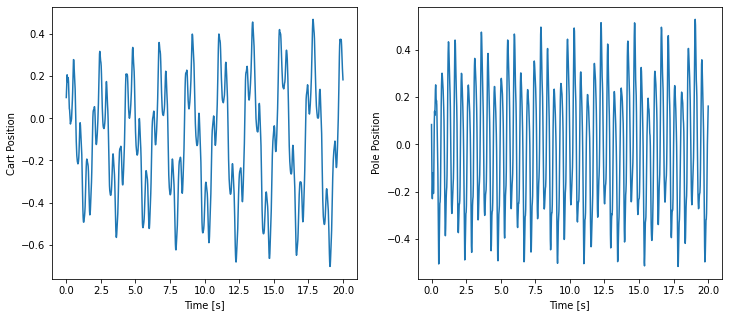

In [2]:
agent_id = 1607352660 # inverted pendulum no vel, continuous action

chiefinv = Chiefinvestigator(agent_id)
try:
    SAVE_DIR = "analysis/sindy_autoencoder/storage/"
    training_data = pickle.load(open(SAVE_DIR+"training_data.pkl", "rb"))
    testing_data = pickle.load(open(SAVE_DIR+"testing_data.pkl", "rb"))
    n_episodes = 1
    activations_all_episodes, inputs_all_episodes, actions_all_episodes, states_all_episodes, _ \
        = chiefinv.get_data_over_episodes(n_episodes, "policy_recurrent_layer", chiefinv.get_layer_names()[1])
except:
    # collect data from episodes
    n_episodes = 500
    activations_all_episodes, inputs_all_episodes, actions_all_episodes, states_all_episodes, _ \
        = chiefinv.get_data_over_episodes(n_episodes, "policy_recurrent_layer", chiefinv.get_layer_names()[1])
    print(f"SIMULATED {n_episodes} episodes")

    # create training and testing datasets
    training_size = int(len(inputs_all_episodes) * 0.8)
    dx = np.gradient(activations_all_episodes, axis=0)
    training_data = {'x': activations_all_episodes[:training_size, :],
                     'dx': dx[:training_size, :],
                     'u': inputs_all_episodes[:training_size, :]}
    testing_data = {'x': activations_all_episodes[training_size:, :],
                    'dx': dx[training_size:, :],
                    'u': inputs_all_episodes[training_size:, :]}

plt.figure(figsize=(12, 5))
x = np.linspace(0, 1000*0.02, 1000)
plt.subplot(121)
plt.plot(x, states_all_episodes[:1000, 0])
plt.xlabel("Time [s]")
plt.ylabel("Cart Position")

plt.subplot(122)
plt.plot(x, states_all_episodes[:1000, 1])
plt.xlabel("Time [s]")
plt.ylabel("Pole Position")
plt.show()

## Set up SindyControlAutoencoder 

In [3]:
layers = [64, 32, 8, 4]
poly_order = 2
lib_size = utils.library_size(layers[-1], poly_order, include_control=True)
key = random.PRNGKey(123)

thresholding_frequency, coefficient_theshold = 500, 0.1
hps = {'system_loss_coeff': 1,
       'control_loss_coeff': 1,
       'dx_loss_weight': 1e-4,
       'dz_loss_weight': 1e-6,
       'reg_loss_weight': 1e-5}

batch_size = 5000
num_batches = int(jnp.ceil(len(training_data['x']) / batch_size))
init_params, coefficient_mask = control_autoencoder.build_sindy_control_autoencoder(layers, lib_size, key)

## Plot Coefficients and Coefficient Mask
For now `sindy coefficients` and `coefficient mask` are homogenously initalized to `1`.

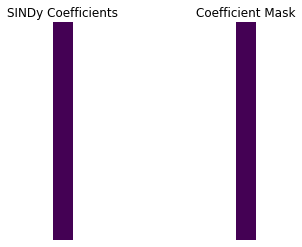

In [4]:
control_autoencoder.plot_params(init_params, coefficient_mask)

## Set up Optimizer

In [5]:
learning_rate = 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(init_params)

## Train the networks

In [6]:
n_epochs, n_refine_epochs = 5000, 1000
print_every = 200 # epochs
all_train_losses = []

start_time = time.time()
for epoch in range(n_epochs):
    for batch in range(num_batches):
        ids = utils.batch_indices(batch, num_batches, batch_size)
        opt_state = control_autoencoder.update_jit(batch, opt_state, opt_update, get_params,
                                                   training_data['x'][ids, :],
                                                   training_data['dx'][ids, :],
                                                   training_data['u'][ids, :], coefficient_mask, hps)

    params = get_params(opt_state)
    if epoch % thresholding_frequency == 0 and epoch > 1:
        coefficient_mask = jnp.abs(params['sindy_coefficients']) > coefficient_theshold
        print("Updated coefficient mask")

    all_train_losses.append(control_autoencoder.loss_jit(params,
                                                         training_data['x'][:batch_size, :],
                                                         training_data['dx'][:batch_size, :],
                                                         training_data['u'][:batch_size, :], coefficient_mask, hps))
    if epoch % print_every == 0:
        utils.print_update(all_train_losses[-1]['total'], epoch, epoch*num_batches, time.time() - start_time)
        start_time = time.time()

print(f"FINISHING TRAINING...\n"
      f"Sparsity: {jnp.sum(coefficient_mask)} active terms")

all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Epoch 0 | Loss 0.46327731013298035 | Updates 0 | This took: 4.8381s
Epoch 200 | Loss 0.04317479953169823 | Updates 16000 | This took: 45.4077s
Epoch 400 | Loss 0.017954399809241295 | Updates 32000 | This took: 45.1562s
Updated coefficient mask
Epoch 600 | Loss 0.006877200212329626 | Updates 48000 | This took: 48.663s
Epoch 800 | Loss 0.005032400134950876 | Updates 64000 | This took: 45.1058s
Updated coefficient mask
Epoch 1000 | Loss 0.00432930001989007 | Updates 80000 | This took: 45.1121s
Epoch 1200 | Loss 0.003848399966955185 | Updates 96000 | This took: 45.0936s
Epoch 1400 | Loss 0.0033903999719768763 | Updates 112000 | This took: 45.4345s
Updated coefficient mask
Epoch 1600 | Loss 0.003104900009930134 | Updates 128000 | This took: 49.3639s
Epoch 1800 | Loss 0.0029206001199781895 | Updates 144000 | This took: 45.2342s
Updated coefficient mask
Epoch 2000 | Loss 0.0027618000749498606 | Updates 160000 | This took: 45.9713s
Epoch 2200 | Loss 0.0026476001366972923 | Updates 176000 | Thi

## Plot Training Losses

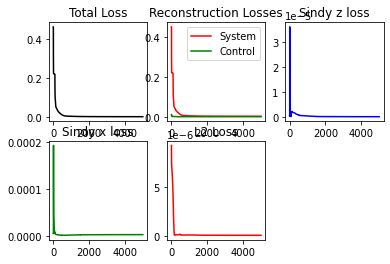

In [7]:
time_steps = np.linspace(0, n_epochs, n_epochs)
plt.figure()
plt.subplot(231)
plt.plot(time_steps, all_train_losses['total'], 'k')
plt.title('Total Loss')

plt.subplot(232)
plt.plot(time_steps, all_train_losses['sys_loss'], 'r', label='System')
plt.plot(time_steps, all_train_losses['control_loss'], 'g', label='Control')
plt.legend()
plt.title('Reconstruction Losses')

plt.subplot(233)
plt.plot(time_steps, all_train_losses['sindy_z_loss'], 'b')
plt.title('Sindy z loss')

plt.subplot(234)
plt.plot(time_steps, all_train_losses['sindy_x_loss'], 'g')
plt.title('Sindy x loss')

plt.subplot(235)
plt.plot(time_steps, all_train_losses['sindy_regularization_loss'], 'r')
plt.title('L2 Loss')
plt.show()

## Refinement Training

In [8]:
hps['reg_loss_weight'] = 0 # no regularization
print('REFINEMENT...')
all_refine_losses = []

start_time = time.time()
for epoch in range(n_refine_epochs):
    for batch in range(num_batches):
        ids = utils.batch_indices(batch, num_batches, batch_size)
        opt_state = control_autoencoder.update_jit(batch, opt_state, opt_update, get_params,
                                                   training_data['x'][ids, :],
                                                   training_data['dx'][ids, :],
                                                   training_data['u'][ids, :], coefficient_mask, hps)

    all_refine_losses.append(control_autoencoder.loss_jit(get_params(opt_state),
                                                          training_data['x'][:batch_size, :],
                                                          training_data['dx'][:batch_size, :],
                                                          training_data['u'][:batch_size, :], coefficient_mask, hps))
    if epoch % print_every == 0:
        utils.print_update(all_refine_losses[-1]['total'], epoch, epoch*num_batches, time.time() - start_time)
        start_time = time.time()

all_refine_losses = {k: [dic[k] for dic in all_refine_losses] for k in all_refine_losses[0]}

REFINEMENT...
Epoch 0 | Loss 0.0022718999534845352 | Updates 0 | This took: 3.601s
Epoch 200 | Loss 0.002261300105601549 | Updates 16000 | This took: 45.5446s
Epoch 400 | Loss 0.0022517999168485403 | Updates 32000 | This took: 45.0086s
Epoch 600 | Loss 0.002242499962449074 | Updates 48000 | This took: 44.9912s
Epoch 800 | Loss 0.0022354000248014927 | Updates 64000 | This took: 44.968s


## Testing

In [9]:
params = get_params(opt_state)
test_batch_size = 10000 # 10 episodes
test_loss = control_autoencoder.loss_jit(params,
                                         testing_data['x'][:test_batch_size, :],
                                         testing_data['dx'][:test_batch_size, :],
                                         testing_data['u'][:test_batch_size, :],
                                         coefficient_mask, hps)['total']
print(f"Loss on large test batch: {round(test_loss, 6)}")

Loss on large test batch: 0.0020939998794347048


## Saving

In [10]:
state = {'autoencoder': get_params(opt_state),
         'coefficient_mask': coefficient_mask,
         'hps': {'layers': layers,
                 'poly_order': poly_order,
                 'library:size': lib_size,
                 'lr': learning_rate,
                 'epochs': n_epochs,
                 'batch_size': batch_size,
                 'thresholding_frequency': thresholding_frequency,
                 'threshold_coefficient': coefficient_theshold},
         'history': {'train_loss': all_train_losses,
                     'refinement_loss': all_refine_losses}}
control_autoencoder.save_state(state, "SindyControlAutoencoder")

## Visualizations

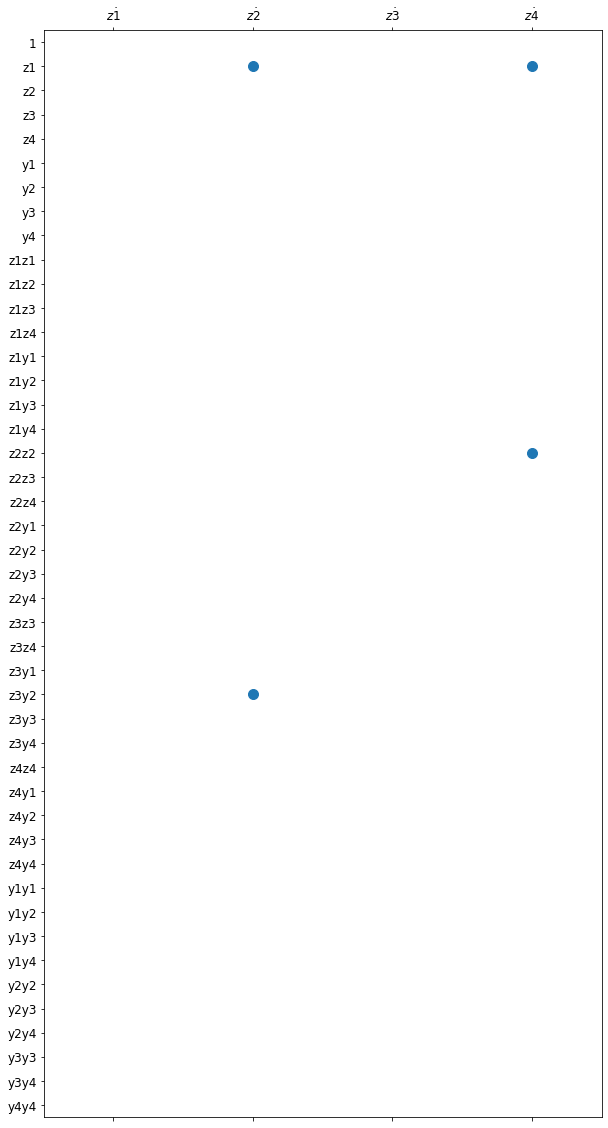

In [11]:
zlabels = ['z1', 'z2', 'z3', 'z4']
ulabels = ['y1', 'y2', 'y3', 'y4']
latex_labels = [r'$\dot{z1}$', r'$\dot{z2}$', r'$\dot{z3}$', r'$\dot{z4}$']
xlabels, ylabels = utils.generate_labels(zlabels, ulabels, poly_order)

fig= plt.figure(figsize=(10, 20))
plt.spy(coefficient_mask * params['sindy_coefficients'],
        marker='o', markersize=10, aspect='auto')
plt.xticks([0, 1, 2, 3], latex_labels, size=12)
yticks = list(np.arange(len(coefficient_mask)))
plt.yticks(yticks, ylabels, size=12)
plt.show()
#plt.subplot(122)
#plt.imshow(coefficient_mask * params['sindy_coefficients'])
#plt.axis('off')
#plt.colorbar()
#plt.show()

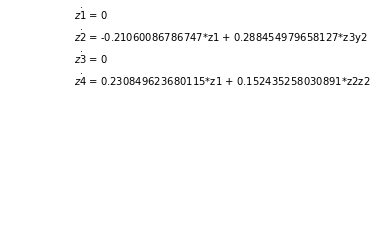

In [12]:
# Print Sparse State Equations
from sympy import symbols
theta_syms = symbols(ylabels)
dz_syms = symbols(latex_labels)

expr = np.matmul(theta_syms, coefficient_mask * params['sindy_coefficients'])

for i, dz_sym in enumerate(dz_syms):
    plt.text(0.2, 1-0.1*i, f"{dz_sym} = {expr[i]}")
plt.axis('off')
plt.show()

In [13]:
# Automatically Interpret latent variables
# TODO

## Plug in SindySystem
Let the Sindy dynamics compute actions to be applied in the environment.

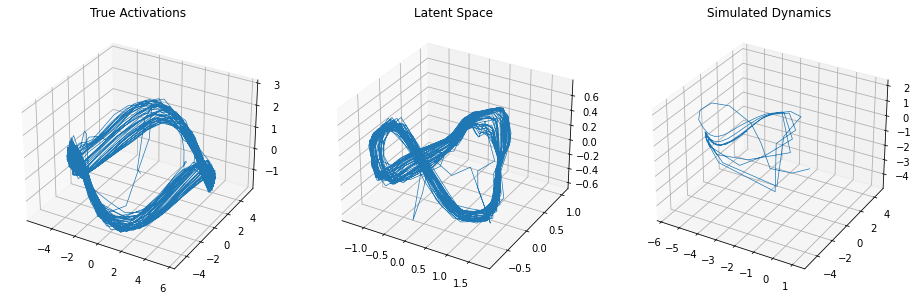

In [16]:
n_points = 1000
[z, y, sindy_predict] = control_autoencoder.batch_compute_latent_space(params, coefficient_mask,
                                                                       activations_all_episodes, inputs_all_episodes)
# Simulate Dynamics and produce 3 episodes
_, _, simulated_activations, simulation_results, actions = control_autoencoder.simulate_episode(chiefinv,
                                                                                                params, coefficient_mask,
                                                                                                render=False)
# Reduce Dimensions
activation_pca = skld.PCA(3)
X_activations = activation_pca.fit_transform(activations_all_episodes)
reconstruction_pca = skld.PCA(3)
X_reconstruction = reconstruction_pca.fit_transform(z)
X_rec_simulation = reconstruction_pca.transform(simulation_results)
X_act_simulation = activation_pca.transform(simulated_activations)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(131, projection=Axes3D.name)
ax.plot(X_activations[:n_points, 0], X_activations[:n_points, 1], X_activations[:n_points, 2],
        linewidth=0.7)
plt.title("True Activations")
ax = fig.add_subplot(132, projection=Axes3D.name)
ax.plot(X_reconstruction[:n_points, 0], X_reconstruction[:n_points, 1], X_reconstruction[:n_points, 2],
        linewidth=0.7)
plt.title("Latent Space")
ax =fig.add_subplot(133, projection=Axes3D.name)
ax.plot(X_act_simulation[:n_points, 0], X_act_simulation[:n_points, 1], X_act_simulation[:n_points, 2],
        linewidth=0.7)
plt.title("Simulated Dynamics")
plt.show()

Activations projected into latent space look comparable to the true activations.

However, the error during simulation looks much greater. Simulation means taking initial conditions for input
and state from environment and network, respectively. From there on dynamics are integrated one timestep using
`scipy.integrate.odeint`. The new `synthetic` (as it is simply computed using the latent space) state is transformed
into an action. The next control input into the latent space is then computed through the environment and through the networks.